# Mushroom TinyML: Balanced Sampling & Collaborative Optimization

**Target:** ESP32-S3 (Int8 TFLite)  
**Features:**
1.  **Balanced Sampling:** Creates equal-probability sampling from all classes to handle imbalance.
2.  **Data Augmentation:** Rotation, Flip, Zoom, Contrast adjustments.
3.  **Optimization:** Pruning -> Clustering -> QAT.

In [2]:
# 1. STRICT VERSION FIX (Run Once & Restart Kernel)
# This fixes 'ModuleNotFoundError: No module named tensorflow.compat' 
# by installing compatible versions of TF and Keras.
!pip uninstall -y tensorflow tensorflow-intel tensorflow-gpu tf-keras keras tensorflow-model-optimization
!pip install tensorflow==2.15.0 tf_keras==2.15.0 tensorflow-model-optimization numpy pandas matplotlib

print("Install complete. PLEASE RESTART KERNEL NOW via 'Kernel > Restart'.")


Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: tensorflow-intel 2.15.0
Uninstalling tensorflow-intel-2.15.0:
  Successfully uninstalled tensorflow-intel-2.15.0
Found existing installation: tf-keras 2.15.0
Uninstalling tf-keras-2.15.0:
  Successfully uninstalled tf-keras-2.15.0
Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0
Found existing installation: tensorflow-model-optimization 0.8.0
Uninstalling tensorflow-model-optimization-0.8.0:
  Successfully uninstalled tensorflow-model-optimization-0.8.0


  Using cached tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata (3.6 kB)
  Using cached tf_keras-2.15.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached tensorflow_model_optimization-0.8.0-py2.py3-none-any.whl.metadata (904 bytes)
  Using cached tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata (5.1 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached tensorflow-2.15.0-cp311-cp311-win_amd64.whl (2.1 kB)
Using cached tf_keras-2.15.0-py3-none-any.whl (1.7 MB)
Using cached tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl (300.9 MB)
Using cached tensorflow_model_optimization-0.8.0-py2.py3-none-any.whl (242 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
Install complete. PLEASE RESTART KERNEL NOW via 'Kernel > Restart'.


In [3]:
import os
import numpy as np
import tensorflow as tf
import tf_keras as keras  # Explicit Keras 2 import
from tf_keras import layers, models, optimizers
import tensorflow_model_optimization as tfmot
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tempfile
import zipfile
import math
from tf_keras import callbacks

# Set Seeds
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")



TensorFlow Version: 2.15.0
Keras Version: 2.15.0


In [4]:
CONFIG = {
    'DATA_DIR': Path("data/Mushrooms"),
    'IMG_SIZE': 240,
    'BATCH_SIZE': 32,
    'VAL_SPLIT': 0.2,
    'EPOCHS_BASELINE': 60,
    'EPOCHS_FINE_TUNE': 20,
    'LEARNING_RATE': 3e-4,
    'FINE_TUNE_LR': 1e-4,
    'NUM_CLUSTERS': 32,
    'SPARSITY': 0.30,
    'SEED': 42,
    'OUTPUT_DIR': Path("output_models")
}
CONFIG['OUTPUT_DIR'].mkdir(exist_ok=True, parents=True)


## 3. Balanced Dataset Pipeline with Augmentation

Scanning files...
Total images: 6713
Classes: ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


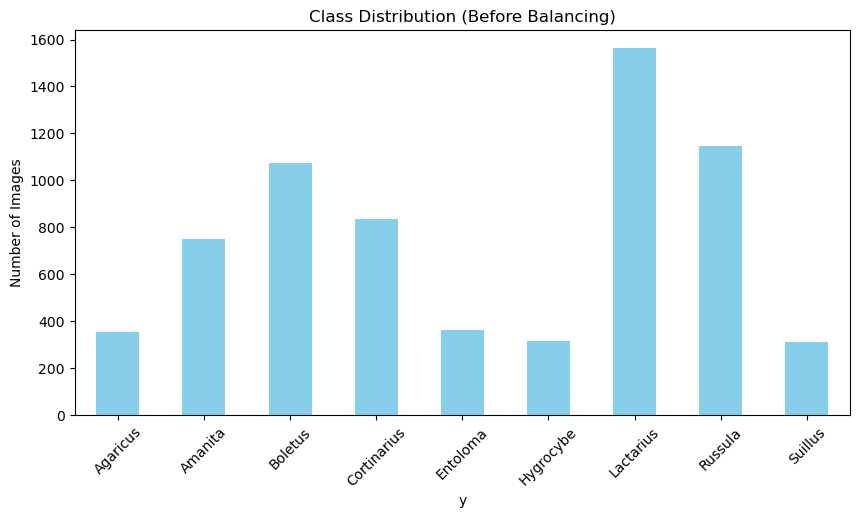

Train size: 5370
Val size: 1343


In [9]:
# 1. Build DataFrame from files
print("Scanning files...")
image_paths = []
labels = []
class_names = sorted([d.name for d in CONFIG["DATA_DIR"].iterdir() if d.is_dir()])
class_indices = {name: i for i, name in enumerate(class_names)}

for cls_name in class_names:
    cls_dir = CONFIG["DATA_DIR"] / cls_name
    for img_path in cls_dir.glob("*"):
        if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            image_paths.append(str(img_path))
            labels.append(class_indices[cls_name])

df = pd.DataFrame({'path': image_paths, 'y': labels})
print(f"Total images: {len(df)}")
print(f"Classes: {class_names}")

# 2. Graph Class Sizes
plt.figure(figsize=(10, 5))
df['y'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.title("Class Distribution (Before Balancing)")
plt.ylabel("Number of Images")
plt.show()

# 3. Split Data
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['y'], random_state=CONFIG["SEED"])
print(f"Train size: {len(train_df)}")
print(f"Val size: {len(val_df)}")


In [10]:
# Augmentation Layers
augment_layers = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
    keras.layers.RandomBrightness(0.1)
])

def load_img(path, label, training=False):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']])
    img = (img / 127.5) - 1.0  # Normalize to [-1, 1]
    
    if training:
        img = augment_layers(img, training=True)
    return img, label

# 1. Create one infinite dataset per class
per_class_datasets = []
num_classes = len(class_names)

print(f"Creating balanced streams for {num_classes} classes...")

for cls_idx in range(num_classes):
    # Get all paths for this specific class
    cls_paths = train_df[train_df['y'] == cls_idx]['path'].tolist()
    cls_labels = [cls_idx] * len(cls_paths)
    
    ds = tf.data.Dataset.from_tensor_slices((cls_paths, cls_labels))
    ds = ds.shuffle(buffer_size=min(1000, len(cls_paths)), seed=CONFIG['SEED'])
    ds = ds.repeat() # Infinite repeat needed for balancing
    
    # Apply loading & augmentation per class stream
    ds = ds.map(lambda p, y: load_img(p, y, training=True), num_parallel_calls=tf.data.AUTOTUNE)
    per_class_datasets.append(ds)

# 2. Sample Equally (The Fix)
# We want every class to have an equal 1/N chance of being picked.
# This ensures the model sees a perfectly flat histogram over time.
equal_weights = [1.0] * num_classes

balanced_train_ds = tf.data.Dataset.sample_from_datasets(
    per_class_datasets, 
    weights=equal_weights, 
    seed=CONFIG['SEED']
)

# 3. Batch and Prefetch
train_ds = balanced_train_ds.batch(CONFIG['BATCH_SIZE']).prefetch(tf.data.AUTOTUNE)

# 4. Validation (No balancing needed, just raw data)
val_paths = val_df['path'].tolist()
val_labels = val_df['y'].tolist()
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(lambda p, y: load_img(p, y, training=False), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(CONFIG['BATCH_SIZE']).prefetch(tf.data.AUTOTUNE)

print("Dataset pipeline fixed: Equal probability sampling active.")

num_classes = len(class_names)
max_per_class = train_df['y'].value_counts().max()  # about 1600 for Lactarius
target_per_class = 1600  # or e.g. 1000 if you want fewer steps

steps_per_epoch = math.ceil(
    (target_per_class * num_classes) / CONFIG['BATCH_SIZE']
)

# Validation still uses the real dataset size
validation_steps = max(1, math.ceil(len(val_df) / CONFIG['BATCH_SIZE']))

print(f"Using steps_per_epoch = {steps_per_epoch}")
print(f"Expected ~{steps_per_epoch * CONFIG['BATCH_SIZE'] // num_classes} samples/class per epoch")



Creating balanced streams for 9 classes...
Dataset pipeline fixed: Equal probability sampling active.
Using steps_per_epoch = 450
Expected ~1600 samples/class per epoch


Sampling one full epoch to verify distribution...


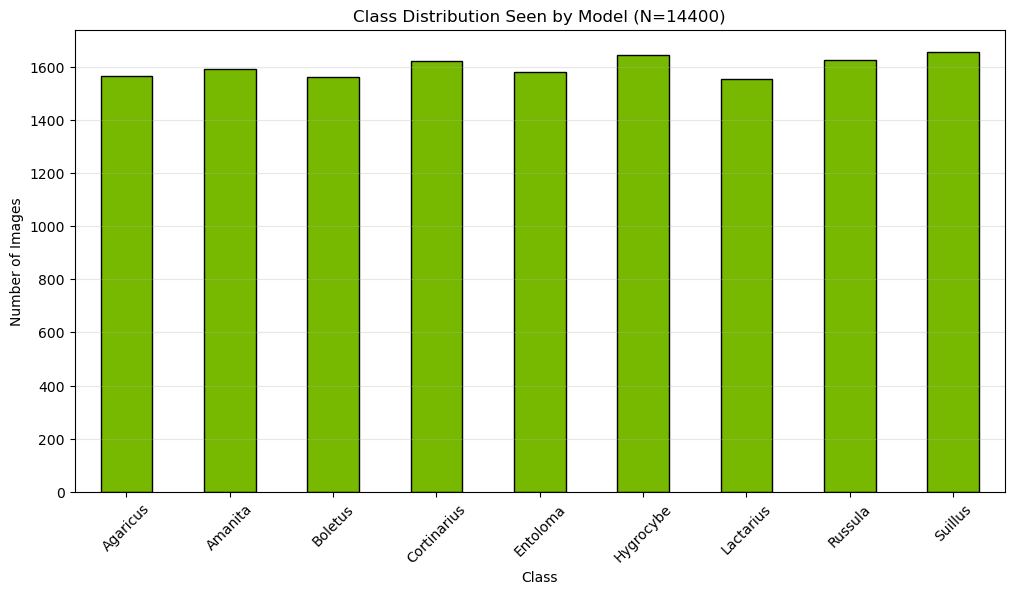

In [11]:
# --- VISUALIZATION: Verify Class Balance ---
import matplotlib.pyplot as plt
import pandas as pd

print("Sampling one full epoch to verify distribution...")
labels_seen = []

# We sample 'steps_per_epoch' batches to simulate what the model sees in 1 epoch
for images, labels in train_ds.take(steps_per_epoch):
    labels_seen.extend(labels.numpy())

# Map indices to names
label_names = [class_names[i] for i in labels_seen]

# Plot
plt.figure(figsize=(12, 6))
pd.Series(label_names).value_counts().sort_index().plot(kind='bar', color='#76b900', edgecolor='black')
plt.title(f"Class Distribution Seen by Model (N={len(labels_seen)})")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()


## 4. Model Training

In [8]:
def build_model(num_classes):
    base_model = keras.applications.MobileNetV2(
        input_shape=(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], 3),
        include_top=False,
        weights='imagenet',
        alpha=0.5   # bump width a bit if VRAM allows; else keep 0.35
    )

    # First phase: freeze backbone
    base_model.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes)(x)

    model = keras.Model(inputs=base_model.input, outputs=outputs)
    return model

baseline_model = build_model(num_classes)

# Phase 1: train head only
baseline_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)



3201480/3201480 [==============================] - 0s 0us/step


In [9]:
baseline_callbacks = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True,
        verbose=1,
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1,
    ),
]

history = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG['EPOCHS_BASELINE'],
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=baseline_callbacks,
)


Epoch 1/60


450/450 [==============================] - 86s 155ms/step - loss: 2.2973 - accuracy: 0.1227 - val_loss: 2.3866 - val_accuracy: 0.0961 - lr: 3.0000e-04
Epoch 2/60
450/450 [==============================] - 65s 144ms/step - loss: 2.2213 - accuracy: 0.1428 - val_loss: 2.0704 - val_accuracy: 0.1735 - lr: 3.0000e-04
Epoch 3/60
450/450 [==============================] - 65s 145ms/step - loss: 2.1754 - accuracy: 0.1582 - val_loss: 2.1501 - val_accuracy: 0.1705 - lr: 3.0000e-04
Epoch 4/60
450/450 [==============================] - 63s 140ms/step - loss: 2.1495 - accuracy: 0.1667 - val_loss: 2.0552 - val_accuracy: 0.2435 - lr: 3.0000e-04
Epoch 5/60
450/450 [==============================] - 62s 139ms/step - loss: 2.1278 - accuracy: 0.1767 - val_loss: 2.0603 - val_accuracy: 0.2710 - lr: 3.0000e-04
Epoch 6/60
450/450 [==============================] - 62s 139ms/step - loss: 2.1221 - accuracy: 0.1793 - val_loss: 2.2089 - val_accuracy: 0.2055 - lr: 3.0000e-04
Epoch 7/60
450/450 [======

In [10]:
# Phase 2: unfreeze backbone
for layer in baseline_model.layers:
    layer.trainable = True

baseline_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG['FINE_TUNE_LR']),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

fine_tune_history = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG['EPOCHS_FINE_TUNE'],
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=baseline_callbacks,
)


Epoch 1/20
450/450 [==============================] - 263s 526ms/step - loss: 2.0150 - accuracy: 0.2341 - val_loss: 2.6648 - val_accuracy: 0.1981 - lr: 1.0000e-04
Epoch 2/20
450/450 [==============================] - 220s 489ms/step - loss: 1.8171 - accuracy: 0.3026 - val_loss: 2.5411 - val_accuracy: 0.2777 - lr: 1.0000e-04
Epoch 3/20
450/450 [==============================] - 226s 503ms/step - loss: 1.7149 - accuracy: 0.3333 - val_loss: 2.3730 - val_accuracy: 0.2904 - lr: 1.0000e-04
Epoch 4/20
450/450 [==============================] - 248s 552ms/step - loss: 1.6327 - accuracy: 0.3711 - val_loss: 1.7960 - val_accuracy: 0.4252 - lr: 1.0000e-04
Epoch 5/20
450/450 [==============================] - 238s 528ms/step - loss: 1.5726 - accuracy: 0.3935 - val_loss: 1.7089 - val_accuracy: 0.4691 - lr: 1.0000e-04
Epoch 6/20
450/450 [==============================] - 245s 544ms/step - loss: 1.5249 - accuracy: 0.4067 - val_loss: 2.2384 - val_accuracy: 0.4140 - lr: 1.0000e-04
Epoch 7/20
450/450 [==

In [11]:
# Correct evaluation (only pass val_ds once)
val_loss, baseline_model_accuracy = baseline_model.evaluate(val_ds, verbose=0)
print('Baseline val accuracy:', baseline_model_accuracy)

# Build a proper output path and save there
output_dir = CONFIG['OUTPUT_DIR']
output_dir.mkdir(parents=True, exist_ok=True)   # if you're using pathlib.Path

model_path = output_dir / ("baseline_balanced_" + str(baseline_model_accuracy) + ".h5")
print("Saving model to:", model_path)

# Keras can take a str or PathLike in recent versions, but str is safest
keras.models.save_model(baseline_model, str(model_path), include_optimizer=True)


Baseline val accuracy: 0.4690990447998047
Saving model to: output_models\baseline_balanced_0.4690990447998047.h5


C:\Users\adamk\AppData\Local\Temp\ipykernel_16836\418674382.py:13: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(baseline_model, str(model_path), include_optimizer=True)


In [12]:
baseline_model = keras.models.load_model(str(model_path))

baseline_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


## 5. Collaborative Optimization
**Step 2: Pruning**

In [13]:
fine_tune_callbacks = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1,
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1,
    ),
]


In [14]:
# Pruning Parameters
pruning_params = {
  'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(
      target_sparsity=CONFIG['SPARSITY'],
      begin_step=0, 
      end_step=-1, 
      frequency=100
  )
}

# Wrap model for pruning
model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(baseline_model, **pruning_params)

model_for_pruning.compile(
    optimizer=optimizers.Adam(learning_rate=CONFIG['FINE_TUNE_LR']),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("Starting Pruning...")
model_for_pruning.fit(
    train_ds, 
    epochs=CONFIG['EPOCHS_FINE_TUNE'], 
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[tfmot.sparsity.keras.UpdatePruningStep()] + fine_tune_callbacks
)

model_pruned = tfmot.sparsity.keras.strip_pruning(model_for_pruning)


Starting Pruning...
Epoch 1/20
450/450 [==============================] - 251s 481ms/step - loss: 1.5351 - accuracy: 0.4072 - val_loss: 1.9187 - val_accuracy: 0.4311 - lr: 1.0000e-04
Epoch 2/20
450/450 [==============================] - 212s 472ms/step - loss: 1.5092 - accuracy: 0.4154 - val_loss: 2.1938 - val_accuracy: 0.3663 - lr: 1.0000e-04
Epoch 3/20
450/450 [==============================] - 216s 481ms/step - loss: 1.4702 - accuracy: 0.4301 - val_loss: 1.9020 - val_accuracy: 0.4378 - lr: 1.0000e-04
Epoch 4/20
450/450 [==============================] - 212s 472ms/step - loss: 1.4346 - accuracy: 0.4425 - val_loss: 2.0546 - val_accuracy: 0.4594 - lr: 1.0000e-04
Epoch 5/20
450/450 [==============================] - ETA: 0s - loss: 1.4268 - accuracy: 0.4437
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
450/450 [==============================] - 217s 482ms/step - loss: 1.4268 - accuracy: 0.4437 - val_loss: 2.2283 - val_accuracy: 0.4013 - lr: 1.0000e-04
Epoc

In [15]:
def print_model_weights_sparsity(model):
    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

def print_model_weight_clusters(model):
    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            # ignore auxiliary quantization weights
            if "quantize_layer" in weight.name:
                continue
            if "kernel" in weight.name:
                unique_count = len(np.unique(weight))
                print(
                    f"{layer.name}/{weight.name}: {unique_count} clusters "
                )



In [16]:
print("Pruned Model Weights Sparsity:")
print_model_weights_sparsity(model_pruned)


Pruned Model Weights Sparsity:
Conv1/kernel:0: 30.09% sparsity  (130/432)
expanded_conv_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/144)
expanded_conv_project/kernel:0: 29.69% sparsity  (38/128)
block_1_expand/kernel:0: 29.95% sparsity  (115/384)
block_1_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/432)
block_1_project/kernel:0: 29.95% sparsity  (230/768)
block_2_expand/kernel:0: 30.01% sparsity  (461/1536)
block_2_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/864)
block_2_project/kernel:0: 30.01% sparsity  (461/1536)
block_3_expand/kernel:0: 30.01% sparsity  (461/1536)
block_3_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/864)
block_3_project/kernel:0: 30.01% sparsity  (461/1536)
block_4_expand/kernel:0: 30.01% sparsity  (461/1536)
block_4_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/864)
block_4_project/kernel:0: 30.01% sparsity  (461/1536)
block_5_expand/kernel:0: 30.01% sparsity  (461/1536)
block_5_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/864)
block_5_pro

**Step 3: Clustering** (16 Clusters, Preserving Sparsity)

In [17]:
from tensorflow_model_optimization.python.core.clustering.keras.experimental import cluster

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization
cluster_weights = cluster.cluster_weights

clustering_params = {
  'number_of_clusters': CONFIG['NUM_CLUSTERS'],
  'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS,
  'preserve_sparsity': True
}

model_clustered = cluster_weights(model_pruned, **clustering_params)

model_clustered.compile(
    optimizer=optimizers.Adam(learning_rate=CONFIG['FINE_TUNE_LR']),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("Starting Clustering...")
model_clustered.fit(
    train_ds, 
    epochs=CONFIG['EPOCHS_FINE_TUNE'], 
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks= fine_tune_callbacks

)

model_clustered_stripped = tfmot.clustering.keras.strip_clustering(model_clustered)

print("Model sparsity:\n")
print_model_weights_sparsity(model_clustered_stripped)

print("\nModel clusters:\n")
print_model_weight_clusters(model_clustered_stripped)


Starting Clustering...
Epoch 1/20
450/450 [==============================] - 222s 450ms/step - loss: 1.4839 - accuracy: 0.4264 - val_loss: 1.5325 - val_accuracy: 0.5019 - lr: 1.0000e-04
Epoch 2/20
450/450 [==============================] - 197s 437ms/step - loss: 1.4044 - accuracy: 0.4527 - val_loss: 1.5779 - val_accuracy: 0.5086 - lr: 1.0000e-04
Epoch 3/20
450/450 [==============================] - ETA: 0s - loss: 1.3606 - accuracy: 0.4649
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
450/450 [==============================] - 197s 439ms/step - loss: 1.3606 - accuracy: 0.4649 - val_loss: 1.9741 - val_accuracy: 0.4289 - lr: 1.0000e-04
Epoch 4/20
450/450 [==============================] - 197s 438ms/step - loss: 1.3067 - accuracy: 0.4858 - val_loss: 2.0609 - val_accuracy: 0.4140 - lr: 5.0000e-05
Epoch 5/20
450/450 [==============================] - ETA: 0s - loss: 1.2921 - accuracy: 0.4885
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.4999999368446

In [18]:
# PCQAT: sparsity- and cluster-preserving quantization-aware training
quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(
    model_clustered_stripped
)

pcqat_model = tfmot.quantization.keras.quantize_apply(
    quant_aware_annotate_model,
    tfmot.experimental.combine.Default8BitClusterPreserveQuantizeScheme(
        preserve_sparsity=True
    ),
)

pcqat_model.compile(
    optimizer=optimizers.Adam(learning_rate=CONFIG["FINE_TUNE_LR"]),  # 1e-5
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

print("Train PCQAT model...")
pcqat_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG["EPOCHS_FINE_TUNE"],  # e.g. 10
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks = fine_tune_callbacks
)


Train PCQAT model...
Epoch 1/20
450/450 [==============================] - 317s 650ms/step - loss: 1.9125 - accuracy: 0.2941 - val_loss: 1.8832 - val_accuracy: 0.3619 - lr: 1.0000e-04
Epoch 2/20
450/450 [==============================] - 286s 636ms/step - loss: 1.5181 - accuracy: 0.4115 - val_loss: 1.3782 - val_accuracy: 0.5279 - lr: 1.0000e-04
Epoch 3/20
450/450 [==============================] - 286s 635ms/step - loss: 1.4151 - accuracy: 0.4497 - val_loss: 1.3057 - val_accuracy: 0.5689 - lr: 1.0000e-04
Epoch 4/20
450/450 [==============================] - 286s 635ms/step - loss: 1.4109 - accuracy: 0.4499 - val_loss: 0.9169 - val_accuracy: 0.6821 - lr: 1.0000e-04
Epoch 5/20
450/450 [==============================] - 286s 635ms/step - loss: 1.3845 - accuracy: 0.4598 - val_loss: 1.3543 - val_accuracy: 0.5652 - lr: 1.0000e-04
Epoch 6/20
450/450 [==============================] - ETA: 0s - loss: 1.3615 - accuracy: 0.4672
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.9999998736893

In [19]:
print("\nPCQAT Model clusters:")
print_model_weight_clusters(pcqat_model)
print("\nPCQAT Model sparsity:")
print_model_weights_sparsity(pcqat_model)



PCQAT Model clusters:
quant_Conv1/Conv1/kernel:0: 32 clusters 
quant_expanded_conv_depthwise/expanded_conv_depthwise/depthwise_kernel:0: 144 clusters 
quant_expanded_conv_project/expanded_conv_project/kernel:0: 32 clusters 
quant_block_1_expand/block_1_expand/kernel:0: 32 clusters 
quant_block_1_depthwise/block_1_depthwise/depthwise_kernel:0: 432 clusters 
quant_block_1_project/block_1_project/kernel:0: 32 clusters 
quant_block_2_expand/block_2_expand/kernel:0: 32 clusters 
quant_block_2_depthwise/block_2_depthwise/depthwise_kernel:0: 864 clusters 
quant_block_2_project/block_2_project/kernel:0: 32 clusters 
quant_block_3_expand/block_3_expand/kernel:0: 32 clusters 
quant_block_3_depthwise/block_3_depthwise/depthwise_kernel:0: 864 clusters 
quant_block_3_project/block_3_project/kernel:0: 32 clusters 
quant_block_4_expand/block_4_expand/kernel:0: 32 clusters 
quant_block_4_depthwise/block_4_depthwise/depthwise_kernel:0: 864 clusters 
quant_block_4_project/block_4_project/kernel:0: 32 c

In [20]:
def get_gzipped_model_size(file):
  # It returns the size of the gzipped model in kilobytes.

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)/1000


In [21]:
# PCQAT model
converter = tf.lite.TFLiteConverter.from_keras_model(pcqat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
pcqat_tflite_model = converter.convert()
pcqat_model_file = 'pcqat_model.tflite'
# Save the model.
with open(pcqat_model_file, 'wb') as f:
    f.write(pcqat_tflite_model)

print("PCQAT model size: ", get_gzipped_model_size(pcqat_model_file), ' KB')


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpn0fsl8w4\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpn0fsl8w4\assets
c:\Users\adamk\anaconda3\envs\micro_speech_model_maker\Lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


PCQAT model size:  604.444  KB


In [22]:
def eval_model(interpreter, dataset):
    # Get I/O info from interpreter
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    input_index = input_details["index"]
    output_index = output_details["index"]

    prediction_digits = []
    true_labels = []

    for i, (image, label) in enumerate(dataset.unbatch()):
        if i % 100 == 0:
            print(f"Evaluated on {i} samples so far.")

        # Convert Tensor -> NumPy, add batch dimension
        img = image.numpy()
        img = np.expand_dims(img, axis=0)

        # Match model input dtype (float / quantized)
        if input_details["dtype"] == np.float32:
            img = img.astype(np.float32)
        else:
            # Quantized input: apply scale/zero-point
            scale, zero_point = input_details["quantization"]
            img = img / scale + zero_point
            img = np.clip(img, np.iinfo(input_details["dtype"]).min,
                               np.iinfo(input_details["dtype"]).max)
            img = img.astype(input_details["dtype"])

        interpreter.set_tensor(input_index, img)
        interpreter.invoke()

        # Read output and get predicted class
        output = interpreter.get_tensor(output_index)
        digit = np.argmax(output[0])
        prediction_digits.append(digit)

        # Save ground-truth label
        true_labels.append(int(label.numpy()))

    prediction_digits = np.array(prediction_digits)
    true_labels = np.array(true_labels)
    accuracy = (prediction_digits == true_labels).mean()
    return accuracy


In [23]:

# Create and use interpreter
interpreter = tf.lite.Interpreter(model_path=pcqat_model_file)
interpreter.allocate_tensors()

pcqat_test_accuracy = eval_model(interpreter, val_ds)

print('Pruned, clustered and quantized TFLite test_accuracy:', pcqat_test_accuracy)
print('Baseline TF test accuracy:', baseline_model_accuracy)


Evaluated on 0 samples so far.
Evaluated on 100 samples so far.
Evaluated on 200 samples so far.
Evaluated on 300 samples so far.
Evaluated on 400 samples so far.
Evaluated on 500 samples so far.
Evaluated on 600 samples so far.
Evaluated on 700 samples so far.
Evaluated on 800 samples so far.
Evaluated on 900 samples so far.
Evaluated on 1000 samples so far.
Evaluated on 1100 samples so far.
Evaluated on 1200 samples so far.
Evaluated on 1300 samples so far.
Pruned, clustered and quantized TFLite test_accuracy: 0.6760982874162323
Baseline TF test accuracy: 0.4690990447998047


## 6. Export to TFLite (Int8)

In [24]:
def representative_data_gen():
    # Take samples from validation set for calibration
    for images, _ in val_ds.take(1000):
        yield [images]

converter = tf.lite.TFLiteConverter.from_keras_model(pcqat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# ESP32 Strict Int8
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

tflite_filename = "mushroom_model_final_" + str(pcqat_test_accuracy) + ".tflite"
tflite_path = CONFIG['OUTPUT_DIR'] / tflite_filename
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

print(f"Saved TFLite model: {tflite_path}")
print(f"Size: {len(tflite_model) / 1024:.2f} KB")


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpe9xumute\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpe9xumute\assets
c:\Users\adamk\anaconda3\envs\micro_speech_model_maker\Lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved TFLite model: output_models\mushroom_model_final_0.6760982874162323.tflite
Size: 957.36 KB


In [25]:
def generate_c_header(tflite_data, path):
    hex_array = ", ".join([f"0x{b:02x}" for b in tflite_data])
    c_code = f"""
#ifndef MUSHROOM_MODEL_H
#define MUSHROOM_MODEL_H

// Auto-generated Mushroom Model
// Size: {len(tflite_data)} bytes

#include <stddef.h>

const unsigned int mushroom_model_len = {len(tflite_data)};

const unsigned char mushroom_model[] __attribute__((aligned(16))) = {{
    {hex_array}
}};

#endif // MUSHROOM_MODEL_H
"""
    with open(path, "w") as f:
        f.write(c_code)
    print(f"Header saved to {path}")

generate_c_header(tflite_model, CONFIG['OUTPUT_DIR'] / "mushroom_model_longtrain.h")


Header saved to output_models\mushroom_model_longtrain.h


Generating visualizations...

--- Classification Report ---
              precision    recall  f1-score   support

    Agaricus       0.53      0.72      0.61        54
     Amanita       0.67      0.70      0.69       118
     Boletus       0.92      0.74      0.82       165
 Cortinarius       0.51      0.67      0.58       117
    Entoloma       0.73      0.57      0.64        53
   Hygrocybe       0.56      0.86      0.68        44
   Lactarius       0.76      0.67      0.71       231
     Russula       0.85      0.67      0.75       169
     Suillus       0.45      0.65      0.53        49

    accuracy                           0.69      1000
   macro avg       0.66      0.69      0.67      1000
weighted avg       0.72      0.69      0.70      1000



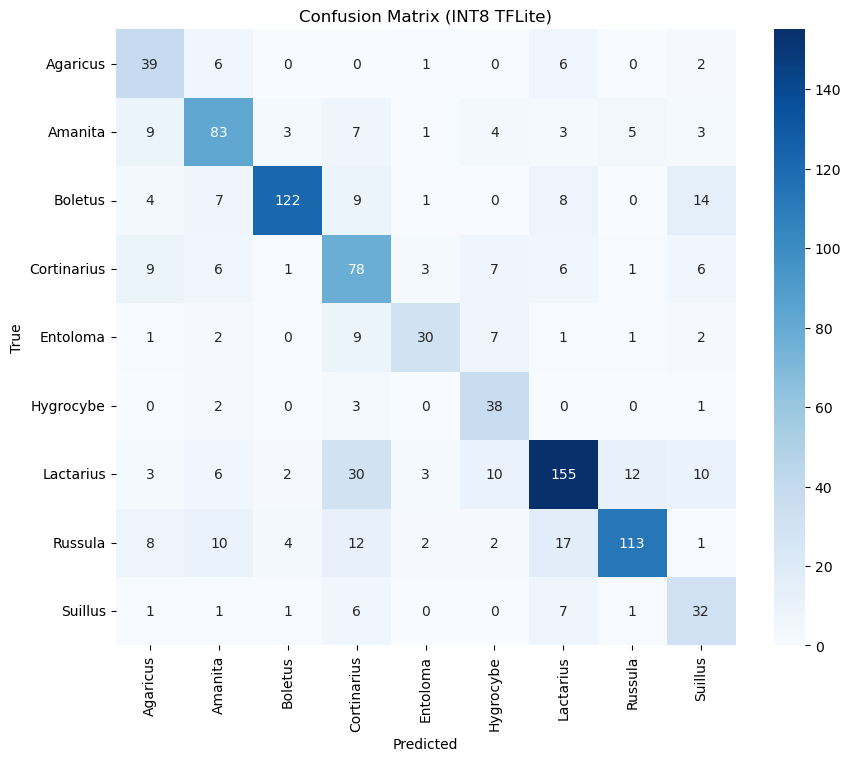

In [12]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def visualize_results(interpreter, dataset, class_names):
    print("Generating visualizations...")
    
    # Get I/O details
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    input_index = input_details["index"]
    output_index = output_details["index"]
    
    y_true = []
    y_pred = []
    
    # Iterate through validation set
    # Note: We take 1000 samples or the whole set to generate metrics
    for i, (image, label) in enumerate(dataset.unbatch()):
        if i >= 1000: break # Limit for speed if dataset is huge
        
        # Preprocess for TFLite (Quantization handling)
        img = image.numpy()
        img = np.expand_dims(img, axis=0)
        
        if input_details["dtype"] != np.float32:
            scale, zero_point = input_details["quantization"]
            img = img / scale + zero_point
            img = np.clip(img, -128, 127).astype(input_details["dtype"])
            
        interpreter.set_tensor(input_index, img)
        interpreter.invoke()
        output = interpreter.get_tensor(output_index)
        
        y_pred.append(np.argmax(output[0]))
        y_true.append(int(label.numpy()))

    # 1. Classification Report
    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # 2. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (INT8 TFLite)')
    plt.show()

# Run the visualization
# Re-create interpreter to ensure fresh state
model_file_name = "mushroom_model_final_0.6760982874162323.tflite"
#interpreter_viz = tf.lite.Interpreter(model_path=str(tflite_path))
interpreter_viz = tf.lite.Interpreter(model_path=model_file_name)
interpreter_viz.allocate_tensors()

visualize_results(interpreter_viz, val_ds, class_names)
